In [1]:
from PIL import Image
from tqdm import tqdm

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import utils

In [2]:
# data directory
data_dir = "../data/"
images_files = os.listdir(data_dir)
images_files = [i for i in images_files if "Shinkai" in i]
images_files.sort()

images_files

['couple1._Shinkai.jpg', 'couple2._Shinkai.jpg', 'couple3._Shinkai.jpg']

In [3]:
origin_images_files = os.listdir(data_dir)
origin_images_files = [i for i in origin_images_files if "._" not in i]
origin_images_files.sort()

origin_images_files

['couple1.jpeg', 'couple2.webp', 'couple3.jpeg']

In [4]:
# load images
from rembg import remove

images = []
cartoon_images = []
backgrounds = []

for im in images_files:
    img = Image.open(os.path.join(data_dir, im)).convert("RGB")
    print(im)
    print(f"image size : {img.size}")    
    cartoon_images.append(np.array(img))
    img = remove(np.array(img))
    backgrounds.append(img[:, :, -1]==0)
    img = Image.fromarray(img)
    img = np.array(img.convert("RGB"))
    images.append(img)
    
# load images

origin_images = []

for im in origin_images_files:
    img = Image.open(os.path.join(data_dir, im)).convert("RGB")
    print(im)
    print(f"image size : {img.size}")    
    
    origin_images.append(np.array(img))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


couple1._Shinkai.jpg
image size : (452, 452)
couple2._Shinkai.jpg
image size : (452, 452)
couple3._Shinkai.jpg
image size : (452, 300)
couple1.jpeg
image size : (550, 550)
couple2.webp
image size : (900, 900)
couple3.jpeg
image size : (275, 183)


In [5]:
cartoon_backgrounds = []
for i in range(len(backgrounds)):
    idx = np.where(backgrounds[i])
    cartoon_backgrounds.append(cartoon_images[i] * np.expand_dims(backgrounds[i].astype(float), axis=2))

In [6]:
backgrounds[0].shape

(452, 452)

## 1. Original images

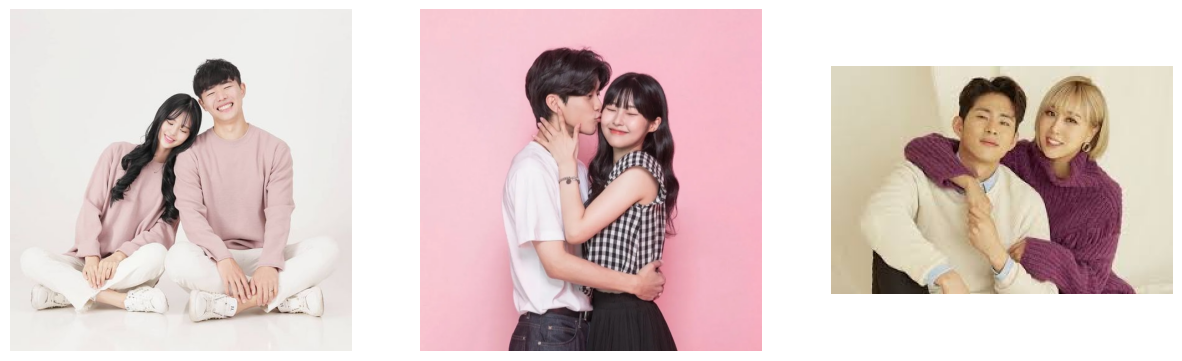

In [7]:
plt.figure(figsize=(5 * len(origin_images), 5))
for i in range(len(origin_images)):
    plt.subplot(1, len(origin_images), i+1)
    plt.imshow(origin_images[i])
    plt.axis("off")

## 1-1. cartoonize

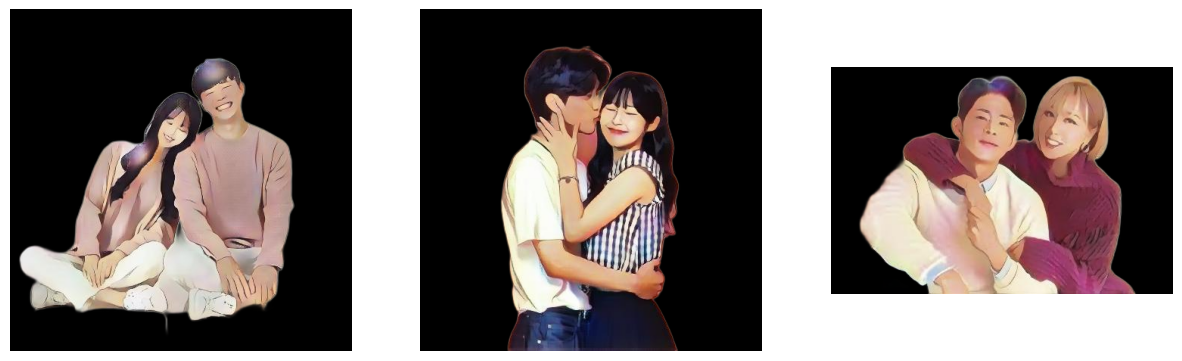

In [8]:
plt.figure(figsize=(5 * len(images), 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])
    plt.axis("off")

## 2. edge detection (without blur)

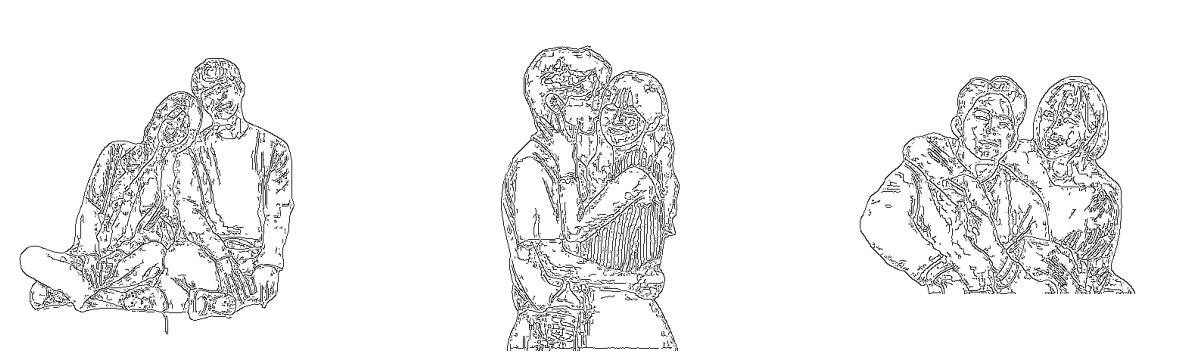

In [9]:
fine_edges = []
plt.figure(figsize=(5 * len(images), 5))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(255-utils.canny_detection(images[i], 30, 50), cmap='gray')
    plt.axis("off")
    
    img = Image.fromarray(255-utils.canny_detection(images[i], 30, 50))
    fine_edges.append(255-utils.canny_detection(images[i], 30, 50))
    img.save(f"../edges/{i}.png")

## 2-1. edge detection(with blur)

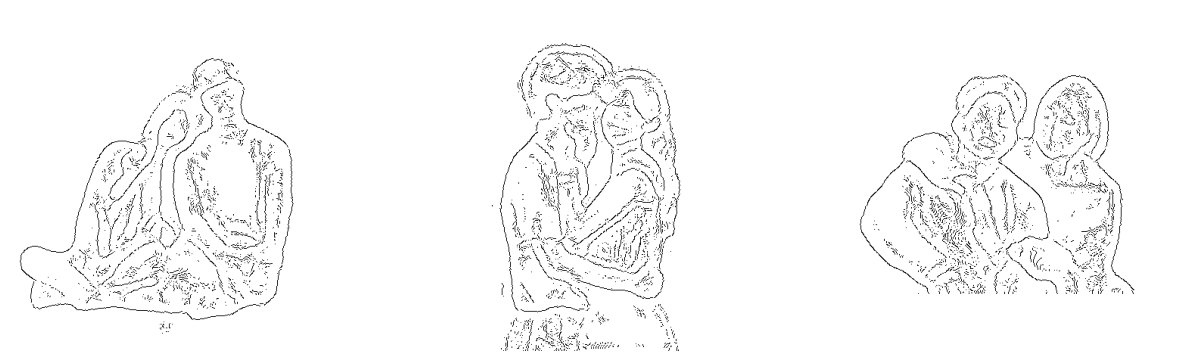

In [10]:
plt.figure(figsize=(5 * len(images), 5))

edges = []
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    smoothing = utils.gaussian_blur(images[i].astype(np.uint8), (51, 51), 5, 5)
    edge = utils.canny_detection(smoothing, 3, 10, apertureSize=3)
    edges.append(edge)
    plt.imshow(255-edge, cmap='gray')
    
    img = Image.fromarray(255-edge)
    img.save(f"../edges/clean/{i}.png")
    plt.axis("off")

## 2-2. edge detection (thicker)

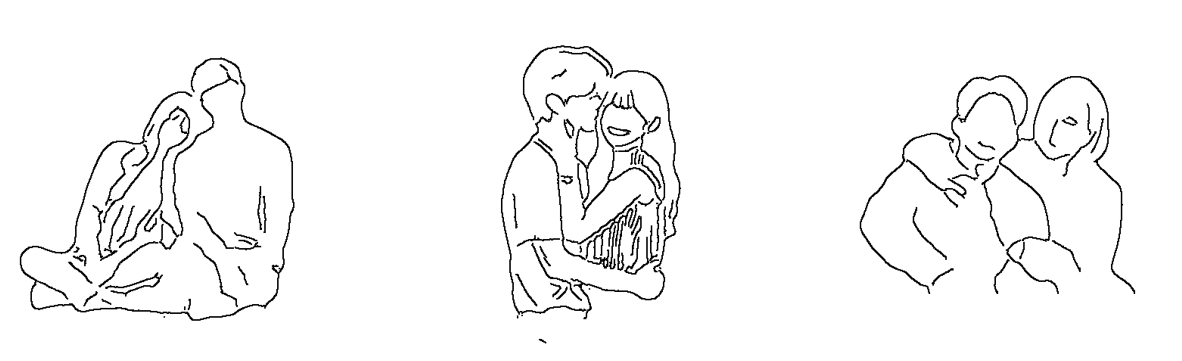

In [11]:
plt.figure(figsize=(5 * len(images), 5))

thick_edges = []
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    smoothing = utils.gaussian_blur(images[i], (25, 15), 3, 3)
    edge = utils.make_edge_thicker(utils.canny_detection(smoothing, 50, 90, apertureSize=3), kernel_size=2)
    thick_edges.append(edge)
    plt.imshow(255-edge, cmap='gray')
    plt.axis("off")

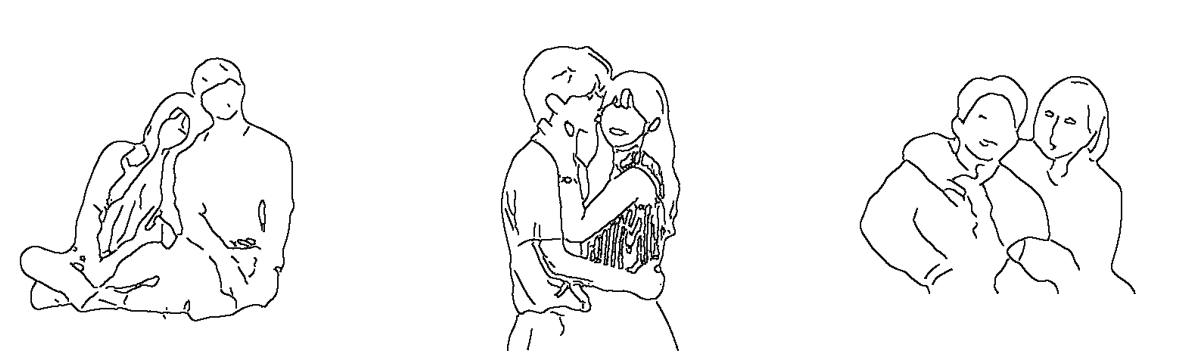

In [12]:
plt.figure(figsize=(5 * len(images), 5))

thick_edges = []
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    smoothing = utils.bilateral_blur(images[i].astype(np.uint8), 3, 150, 5)
    smoothing = utils.median_blur(smoothing, 7)
    smoothing = utils.gaussian_blur(smoothing, (5, 5), 3, 3)
    # plt.imshow(smoothing)
    
    edge = utils.make_edge_thicker(utils.canny_detection(smoothing, 70, 100, apertureSize=3), kernel_size=2)
    thick_edges.append(edge)
    plt.imshow(255-edge, cmap='gray')
    plt.axis("off")

In [13]:
colormap_gray = utils.get_SAM_edges("../masks/masks", thick_edges, score_threshold=0.7)
b = utils.get_SAM_colormap("../masks/masks", cartoon_images, score_threshold=0.7)

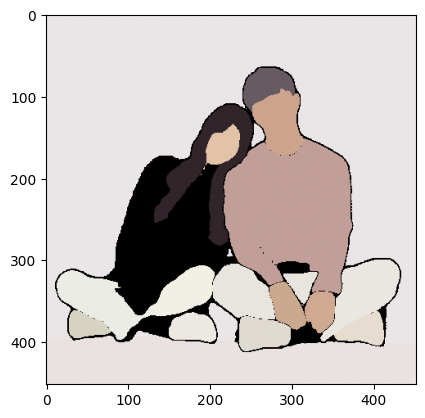

In [14]:
plt.imshow(b[0])

In [15]:
c = utils.fill_large_chunks(b, cartoon_images)

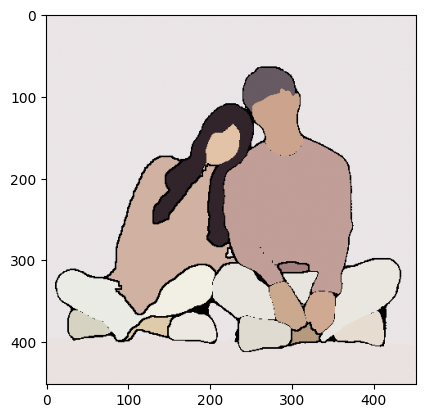

In [16]:
plt.imshow(c[0])

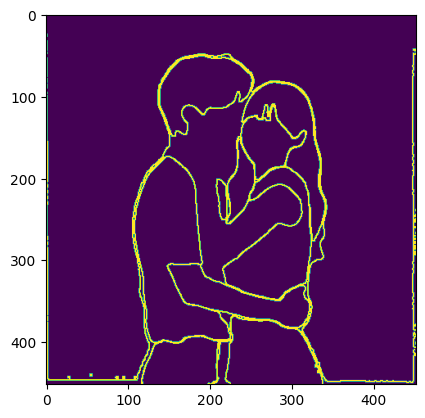

In [17]:
plt.imshow(colormap_gray[1]!=0)
# 0인 공간 어느 일정 크기면 색 채워넣기
# 어느 이하면, 주변 픽셀 max 값 채워넣기
# 중복값 해결

## 3. overlay edge on image (thin edge)

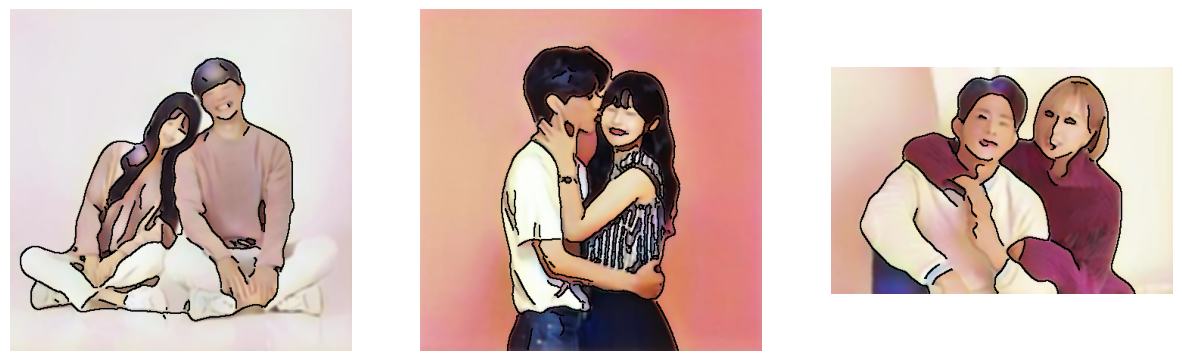

In [ ]:
plt.figure(figsize=(5 * len(images), 5))

for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    img_with_edge = cartoon_images[i].copy()
    img_with_edge = utils.gaussian_blur(img_with_edge, (5, 5), 3, 3)
    # img_with_edge += cartoon_backgrounds[i].astype(np.uint8)
    # img_with_edge[thick_edges[i]!=0] = 0
    img_with_edge[thick_edges[i]!=0] = 0
    plt.imshow(img_with_edge)
    plt.axis("off")

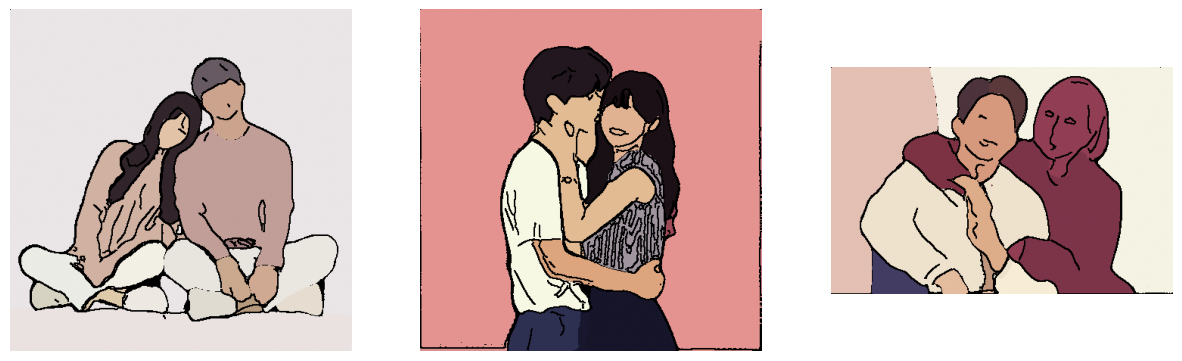

In [21]:
plt.figure(figsize=(5 * len(images), 5))

for i in range(len(images)):
    if i == 0:
        plt.subplot(1, len(images), i+1)
        img_with_edge = c[i].copy()
        # img_with_edge = utils.gaussian_blur(img_with_edge, (5, 5), 3, 3)
        # img_with_edge += cartoon_backgrounds[i].astype(np.uint8)
        # img_with_edge[thick_edges[i]!=0] = 0
        img_with_edge[thick_edges[i]!=0] = 0
        plt.imshow(img_with_edge, cmap='gray')
        plt.axis("off") 
    else:
        plt.subplot(1, len(images), i+1)
        img_with_edge = c[i].copy()
        # img_with_edge = utils.gaussian_blur(img_with_edge, (5, 5), 3, 3)
        # img_with_edge += cartoon_backgrounds[i].astype(np.uint8)
        # img_with_edge[thick_edges[i]!=0] = 0
        img_with_edge[thick_edges[i]!=0] = 0
        plt.imshow(img_with_edge, cmap='gray')
        plt.axis("off")

## 3. overlay edge on image (thick edge)

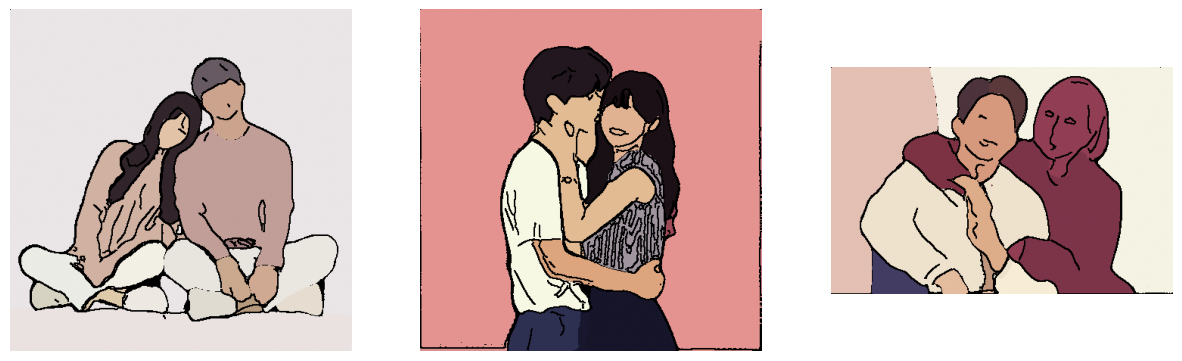

In [23]:
plt.figure(figsize=(5 * len(images), 5))

for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    img_with_edge = c[i].copy()
    # img_with_edge = utils.gaussian_blur(img_with_edge, (5, 5), 3, 3)
    img_with_edge[thick_edges[i]!=0] = 0
    plt.imshow(img_with_edge, cmap='gray')
    plt.axis("off")

## 3-2. overlay edge on image (thick edge, merge color)

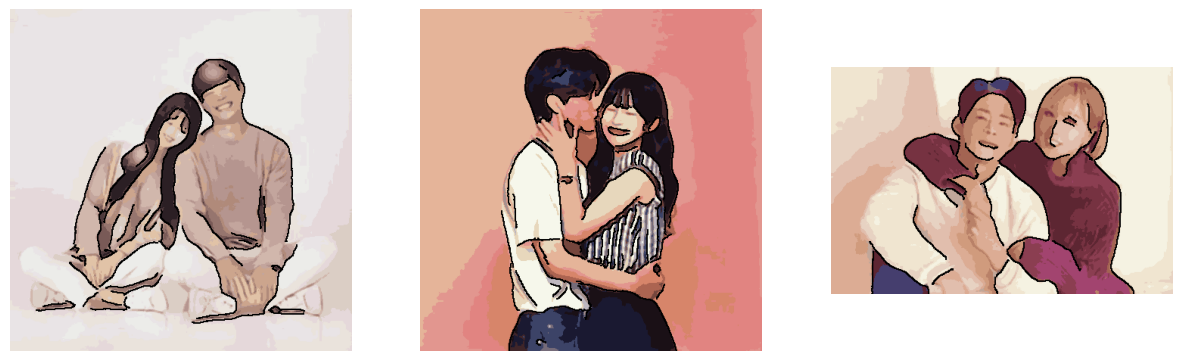

In [ ]:
plt.figure(figsize=(5 * len(images), 5))

for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    img_with_edge = images[i].copy()
    img_with_edge = utils.gaussian_blur(img_with_edge, (3, 3), 3, 3)
    img_merged = utils.color_merge(img_with_edge, 15)
    img_merged[thick_edges[i]!=0] = 0
    plt.imshow(img_merged, cmap='gray')
    plt.axis("off")

In [ ]:
x, y, w, h = 100, 100, 200, 200  # Customize this
initial_contour = np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]])

# Convert to float and reshape for cv2.fitEllipse
initial_contour = np.float32(initial_contour.reshape(-1, 1, 2))

# Perform the active contour model algorithm
# Parameters here are placeholders and should be tuned for your specific case
snake, hierarchy = cv2.findContours(image=fine_edges[0], mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

# # Draw the resulting contour
result = np.zeros_like(images[0])
contours = []

for s in snake:
    contours.append(cv2.drawContours(result, [snake[12].astype(int)], -1, (255, 255, 255), 2))

In [ ]:
mx = []
for c in contours:
    mx.append((c!=0).sum())

In [ ]:
mx.index(max(mx))

0

In [30]:
import pickle as pkl

with open("../data/masks/couple4_Shinkai_mask.pkl", "rb") as f:
    colormap_gray = pkl.load(f)

In [33]:
colormap_gray.sort(key=lambda x:x['segmentation'].sum(), reverse=True)

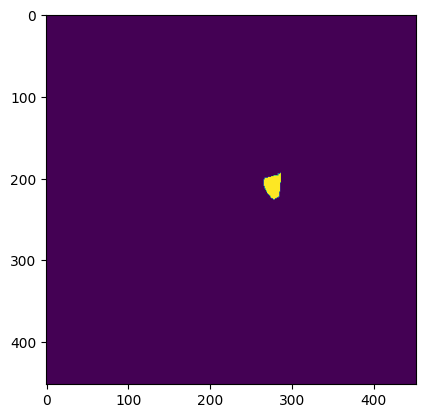

In [113]:
import matplotlib.pyplot as plt

plt.imshow(colormap_gray[48]['segmentation'])
    

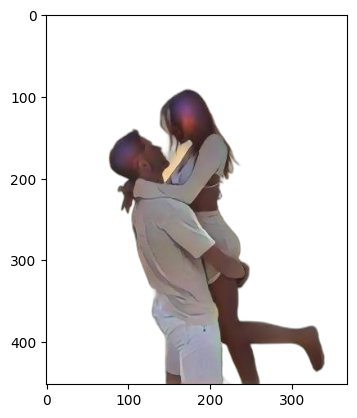

In [218]:
from PIL import Image
import numpy as np
import utils
from rembg import remove

colormap_gray = remove(np.array(Image.open("../data/cartoonized/couple5._Shinkai.jpg")))
plt.imshow(colormap_gray)

In [224]:
idx1, idx2 = np.where(colormap_gray.sum(axis=2)==0)

colormap_gray[idx1, idx2, :]

In [215]:
def colormap_postprocessor(colormap, origin):
    factor = 1
    
    if colormap.max() < 1.1 and origin.max() < 1.1:
        factor = 255
    
    tmp = Image.fromarray((origin * factor).astype(np.uint8))
    origin_gray = np.array(tmp.convert("L"))
    origin_rgb = np.array(tmp.convert("RGB"))
    
    tmp = Image.fromarray((colormap * factor).astype(np.uint8))
    colormap_gray = np.array(tmp.convert("L"))
    colormap_rgb = np.array(tmp.convert("RGB"))
     
    _, segment = cv2.connectedComponents(colormap_gray)
    
    for v in np.unique(segment):
        if v and ((origin_gray * (colormap_gray == v)) - (colormap_gray * (colormap_gray == v)) > 50).sum() > (colormap_gray == v).sum()*0.7:
            idx1, idx2 = np.where(colormap_gray == v)
            rfill = np.median(origin_rgb[idx1, idx2, 0])
            gfill = np.median(origin_rgb[idx1, idx2, 1])
            bfill = np.median(origin_rgb[idx1, idx2, 2])
            
            colormap_rgb[idx1, idx2, 0] *= 0
            colormap_rgb[idx1, idx2, 0] += rfill.astype(np.uint8)
            
            colormap_rgb[idx1, idx2, 1] *= 0
            colormap_rgb[idx1, idx2, 1] += gfill.astype(np.uint8)
            
            colormap_rgb[idx1, idx2, 2] *= 0
            colormap_rgb[idx1, idx2, 2] += bfill.astype(np.uint8)
            
    return colormap_rgb

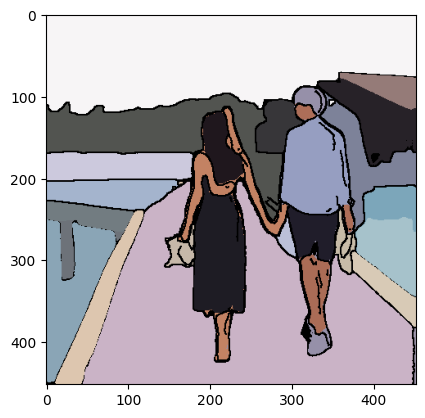

In [216]:
plt.imshow(colormap_postprocessor(a_rgb, origin_rgb))

In [205]:
for v in np.unique(segment):
    if v and ((origin * (colormap_gray == v)) - (colormap_gray * (colormap_gray == v)) > 50).sum() > (colormap_gray == v).sum()*0.7:
        idx1, idx2 = np.where(colormap_gray == v)
        rfill = np.median(origin_rgb[idx1, idx2, 0])
        gfill = np.median(origin_rgb[idx1, idx2, 1])
        bfill = np.median(origin_rgb[idx1, idx2, 2])
        
        a_rgb[idx1, idx2, 0] *= 0
        a_rgb[idx1, idx2, 0] += rfill.astype(np.uint8)
        
        a_rgb[idx1, idx2, 1] *= 0
        a_rgb[idx1, idx2, 1] += gfill.astype(np.uint8)
        
        a_rgb[idx1, idx2, 2] *= 0
        a_rgb[idx1, idx2, 2] += bfill.astype(np.uint8)

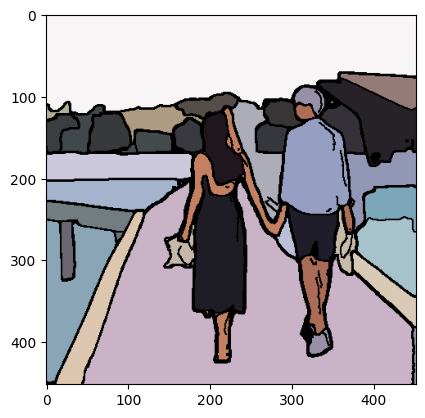

In [206]:
plt.imshow(a_rgb, cmap='gray')

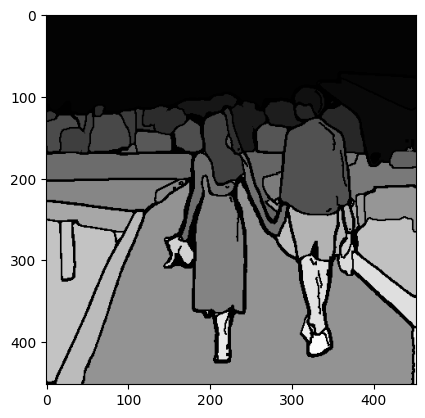

In [183]:
plt.imshow(segment, cmap='gray')

79